## Baseline Reproduce

In [2]:
import os, codecs
import pandas as pd
import numpy as np

%pylab inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

from matplotlib import font_manager as fm, rcParams
import matplotlib.pyplot as plt
os.chdir('/Users/hirahtang/Desktop/DCIC_xiamensharebikes/data')

Populating the interactive namespace from numpy and matplotlib


In [3]:
def bike_fence_format(s):
    s = s.replace('[', '').replace(']', '').split(',')
    s = np.array(s).astype(float).reshape(5, -1)
    return s


# 共享单车停车点位（电子围栏）数据
bike_fence = pd.read_csv('gxdc_tcd.csv')
bike_fence['FENCE_LOC'] = bike_fence['FENCE_LOC'].apply(bike_fence_format)

# 共享单车订单数据
bike_order = pd.read_csv('gxdc_dd.csv')
bike_order = bike_order.sort_values(['BICYCLE_ID', 'UPDATE_TIME'])

---------
## Plotting

In [4]:
dots = bike_order[bike_order['LOCK_STATUS'] == 1].sample(n = 2000)

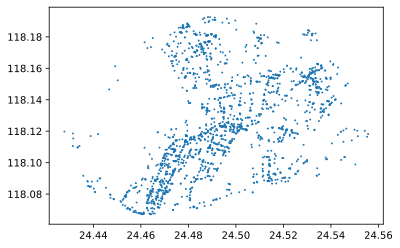

In [5]:
plt.scatter(dots['LATITUDE'], dots['LONGITUDE'],s=1)
plt.show()

----------

## Add Geohash to the order dataset (precision = 9)

In [6]:
import Geohash
bike_order['geohash'] = bike_order.apply(lambda x: 
                        Geohash.encode(x['LATITUDE'], x['LONGITUDE'], precision=9), axis=1)

### Calculate the area of bike fences

In [7]:
from geopy.distance import geodesic

bike_fence['MIN_LATITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.min(x[:, 1]))
bike_fence['MAX_LATITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.max(x[:, 1]))

bike_fence['MIN_LONGITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.min(x[:, 0]))
bike_fence['MAX_LONGITUDE'] = bike_fence['FENCE_LOC'].apply(lambda x: np.max(x[:, 0]))

bike_fence['FENCE_AREA'] = bike_fence.apply(lambda x: geodesic(
    (x['MIN_LATITUDE'], x['MIN_LONGITUDE']), (x['MAX_LATITUDE'], x['MAX_LONGITUDE'])
).meters, axis=1)

bike_fence['FENCE_CENTER'] = bike_fence['FENCE_LOC'].apply(
    lambda x: np.mean(x[:-1, ::-1], 0)
)

### Set geohash precision as 6 is more proper

In [19]:
import Geohash
bike_order['geohash'] = bike_order.apply(
    lambda x: Geohash.encode(x['LATITUDE'], x['LONGITUDE'], precision=6), 
axis=1)

bike_fence['geohash'] = bike_fence['FENCE_CENTER'].apply(
    lambda x: Geohash.encode(x[0], x[1], precision=6)
)

In [20]:
bike_order['UPDATE_TIME'] = pd.to_datetime(bike_order['UPDATE_TIME'])
bike_order['DAY'] = bike_order['UPDATE_TIME'].dt.day.astype(object)
bike_order['DAY'] = bike_order['DAY'].apply(str)

bike_order['HOUR'] = bike_order['UPDATE_TIME'].dt.hour.astype(object)
bike_order['HOUR'] = bike_order['HOUR'].apply(str)
bike_order['HOUR'] = bike_order['HOUR'].str.pad(width=2,side='left',fillchar='0')

bike_order['DAY_HOUR'] = bike_order['DAY'] + bike_order['HOUR']

# 按照经纬度聚合

### Day_Hour as the divider

In [21]:
bike_inflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 1], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY_HOUR'], aggfunc='count', fill_value=0
)

bike_outflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 0], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY_HOUR'], aggfunc='count', fill_value=0
)

### Day as the divider

In [26]:
bike_inflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 1], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

bike_outflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 0], 
                   values='LOCK_STATUS', index=['geohash'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

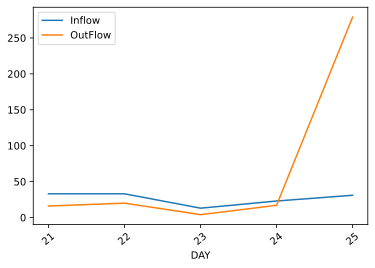

In [27]:
bike_inflow.loc['wsk591'].plot()
bike_outflow.loc['wsk591'].plot()
plt.xticks(list(range(bike_inflow.shape[1])), bike_inflow.columns, rotation=40)
plt.legend(['Inflow', 'OutFlow'])

In [28]:
bike_remain = (bike_inflow - bike_outflow).fillna(0)
bike_remain[bike_remain < 0] = 0  
bike_remain = bike_remain.sum(1)
bike_fence['DENSITY'] = bike_fence['geohash'].map(bike_remain).fillna(0)

In [42]:
(bike_inflow - bike_outflow).sum(1)

geohash
ws7fzr      1.0
ws7fzx    -41.0
ws7fzy   -106.0
ws7fzz   -224.0
ws7gn7      0.0
          ...  
wsk592   -197.0
wsk593    577.0
wsk594     85.0
wsk595      0.0
wsk596     -6.0
Length: 221, dtype: float64

In [31]:
bike_fence[bike_fence['DENSITY'] > 0]

,FENCE_ID,FENCE_LOC,MIN_LATITUDE,MAX_LATITUDE,MIN_LONGITUDE,MAX_LONGITUDE,FENCE_AREA,FENCE_CENTER,geohash,DENSITY
71,七星西路_L_1,"[[118.0915030328, 24.4877226143], [118.0914867...",24.487723,24.487793,118.091487,118.091521,8.490934,"[24.487757653350002, 118.0915037114]",ws7gr1,15.0
72,七星西路_L_2_A,"[[118.0914730185, 24.4878795888], [118.0914614...",24.487880,24.487936,118.091461,118.091492,6.955651,"[24.4879076857, 118.091476746025]",ws7gr1,15.0
73,七星西路_L_2_B,"[[118.0913811138, 24.4883900458], [118.0913661...",24.488390,24.488479,118.091366,118.091399,10.400303,"[24.488434577950002, 118.091382408275]",ws7gr1,15.0
74,七星西路_L_3_A,"[[118.0914298667, 24.4881312594], [118.0914072...",24.488131,24.488207,118.091407,118.091443,9.185904,"[24.4881693499, 118.09142515075]",ws7gr1,15.0
83,七星西路_R_1_B,"[[118.0916956072, 24.4884784545], [118.0917095...",24.488400,24.488478,118.091678,118.091710,9.302605,"[24.4884390896, 118.091693570225]",ws7gr1,15.0
...,...,...,...,...,...,...,...,...,...,...
14051,龙虎山路_R_2,"[[118.1155570078, 24.43223598], [118.115527980...",24.432184,24.432244,118.115510,118.115557,8.231602,"[24.432213882550002, 118.11553359605001]",ws7fzz,63.0
14052,龙虎山路_R_A06001,"[[118.1153732505, 24.4318764949], [118.1153253...",24.431759,24.431882,118.115310,118.115373,15.021586,"[24.4318203038, 118.11534173242501]",ws7fzz,63.0
14053,龙虎山路_R_A06002,"[[118.1157714344, 24.4326259742], [118.1157366...",24.432567,24.432634,118.115721,118.115771,8.961192,"[24.4326004876, 118.115746242575]",ws7fzz,63.0
14054,龙虎山路_R_A06003,"[[118.1161157786, 24.4332002847], [118.1160788...",24.433139,24.433209,118.116062,118.116116,9.474325,"[24.433174188775, 118.116088695475]",ws7fzz,63.0


## 按照最近邻经纬度
### 思路： 按照订单计算与停车点的距离计算潮汐点

In [60]:
# import hnswlib

# p = hnswlib.Index(space='l2', dim=2)
# p.init_index(max_elements=300000, ef_construction=1000, M=32)
# p.set_ef(1024)
# p.set_num_threads(14)

# p.add_items(np.stack(bike_fence['FENCE_CENTER'].values))

In [102]:
import re

bike_fence['STREET'] = bike_fence['FENCE_ID'].apply(lambda x: re.split('[A-Z\d+_]', x)[0])

In [103]:
len(bike_fence['STREET'].unique())

727

In [104]:
# 留存车辆 / 街道停车位总面积，计算得到密度
bike_density = bike_fence.groupby(['STREET'])['geohash'].unique().apply(
    lambda hs: np.sum([bike_remain[x] for x in hs])
) / bike_fence.groupby(['STREET'])['FENCE_AREA'].sum()

# 按照密度倒序
bike_density = bike_density.sort_values(ascending=False).reset_index()

In [107]:
bike_density[:40]

,STREET,0
0,新丰路(火炬路至火炬北路),264.109027
1,展洪北路,140.970740
2,安岭二路,132.477074
3,美湖东路,127.047838
4,华盛路(湖里大道与悦华路段),123.263790
5,涵光路,123.258092
6,西提南路,113.838900
7,莲兴路(莲景路与莲景三路段),111.779036
8,吕岭路(前埔东路至环岛干道段),106.913570
9,吕岭路(环岛东路至展鸿路段),105.306383


In [105]:
len(bike_fence['FENCE_ID'].unique())

14071

In [56]:
bike_fence.shape

(14071, 11)

In [115]:
output = list(bike_density[:40]['STREET'])

In [116]:
output

['新丰路(火炬路至火炬北路)',
 '展洪北路',
 '安岭二路',
 '美湖东路',
 '华盛路(湖里大道与悦华路段)',
 '涵光路',
 '西提南路',
 '莲兴路(莲景路与莲景三路段)',
 '吕岭路(前埔东路至环岛干道段) ',
 '吕岭路(环岛东路至展鸿路段)',
 '环岛干道(吕岭路至莲前东路段 ) ',
 '湖滨一里',
 '湖滨南路(天湖路与斗西路段)',
 '吕岭路 ',
 '玉荷路',
 '台中路',
 '岐山路',
 '望海路',
 '新丰路',
 '映碧路',
 '华盛路(华盛路与宜宾北路交叉路口)',
 '虎仔路',
 '创新路(马垅路至火炬路)',
 '盈翠中路',
 '乌石埔南路',
 '蔡山路',
 '创新路(马垅路至火炬路段)',
 '观日路(会展路至望海路段)',
 '映碧南路',
 '环岛路',
 '观日路(望海路至会展路段 )',
 '莲岳路(嘉禾路',
 '岭下南路',
 '马垄二路',
 '金榜西路',
 '角滨路',
 '金榜路',
 '吕岭路(会展路至前埔路段 )',
 '象屿路',
 '育秀东路']

In [117]:
def return_output(data, forty_list):
#    area = data['FENCE_ID'].split('_')[0]
#    import re
    area = re.split('[A-Z\d+_]', data['FENCE_ID'])[0]
#bike_fence['STREET'] = bike_fence['FENCE_ID'].apply(lambda x: re.split('[A-Z\d+_]', x)[0])
    if area in forty_list:
        data['FENCE_TYPE'] = 1
        data['BELONG_AREA'] = area
    else:
        data['FENCE_TYPE'] = 0
    return data

bike_fence_output = bike_fence.apply(lambda data: return_output(data, output), axis = 1)

In [118]:
result_txt = bike_fence_output[['FENCE_ID', 'FENCE_TYPE', 'BELONG_AREA']]

In [119]:
result_txt[result_txt['FENCE_TYPE'] == 1]

,FENCE_ID,FENCE_TYPE,BELONG_AREA
406,乌石埔南路0_L_1,1,乌石埔南路
407,乌石埔南路0_L_2,1,乌石埔南路
408,乌石埔南路0_R_1,1,乌石埔南路
2408,创新路(马垅路至火炬路段)_L_1,1,创新路(马垅路至火炬路段)
2409,创新路(马垅路至火炬路段)_L_2,1,创新路(马垅路至火炬路段)
...,...,...,...
12358,金榜西路_L_2,1,金榜西路
12359,金榜西路_L_3,1,金榜西路
12360,金榜路0_L_1,1,金榜路
13327,马垄二路_L_1,1,马垄二路


In [120]:
result_txt.to_csv('result.txt', sep = '|', index = False)

In [85]:
def check(data):
    if '市政' in data['FENCE_ID']:
        return True
bike_fence['City'] = bike_fence.apply(check, axis = 1)

In [98]:

#bike_fence['FENCE_ID'].apply(lambda x: re.findall('[A-Z]'))
#print(re.findall('[A-Z][^A-Z]*', text))
#print(re.split('[A-Z\d+]', text))

In [95]:
text = 'sAdBcDa2s1da'
#re.findall
print(re.split('\d+', text))
print(re.split('[A-Z\d+]', text))

['sAdBcDa', 's', 'da']
['s', 'd', 'c', 'a', 's', 'da']


In [121]:
len(bike_fence['STREET'].unique())

727

## KNN 匹配潮汐

In [123]:
from sklearn.neighbors import NearestNeighbors

# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
knn = NearestNeighbors(metric = "haversine", n_jobs=-1, algorithm='brute')
knn.fit(np.stack(bike_fence['FENCE_CENTER'].values))

NearestNeighbors(algorithm='brute', metric='haversine', n_jobs=-1)

### 计算订单中对应的停车点位置

In [129]:
# 需要11s左右
dist, index = knn.kneighbors(bike_order[['LATITUDE','LONGITUDE']], n_neighbors=1)

In [130]:
bike_order['fence'] = bike_fence.iloc[index.flatten()]['FENCE_ID'].values

bike_inflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 1], 
                   values='LOCK_STATUS', index=['fence'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

bike_outflow = pd.pivot_table(bike_order[bike_order['LOCK_STATUS'] == 0], 
                   values='LOCK_STATUS', index=['fence'],
                    columns=['DAY'], aggfunc='count', fill_value=0
)

bike_remain = (bike_inflow - bike_outflow).fillna(0)
bike_remain[bike_remain < 0] = 0  
bike_remain = bike_remain.sum(1)

In [131]:
bike_density = bike_remain / bike_fence.set_index('FENCE_ID')['FENCE_AREA']
bike_density = bike_density.sort_values(ascending=False).reset_index()
bike_density = bike_density.fillna(0)

In [137]:
bike_order.head()

,BICYCLE_ID,LATITUDE,LONGITUDE,LOCK_STATUS,UPDATE_TIME,geohash,DAY,HOUR,DAY_HOUR,fence
34481,0000ff105fd5f9099b866bccd157dc50,24.521156,118.140385,0,2020-12-21 06:32:48,wsk52r,21,06,2106,枋湖北二路0_L_4
41110,0000ff105fd5f9099b866bccd157dc50,24.496578,118.142543,1,2020-12-21 06:50:18,wsk527,21,06,2106,金安路_L_A02001
66106,0000ff105fd5f9099b866bccd157dc50,24.496582,118.142612,0,2020-12-21 08:23:32,wsk527,21,08,2108,金安路_L_A02001
65945,0000ff105fd5f9099b866bccd157dc50,24.481350,118.167496,1,2020-12-21 08:44:34,wsk52b,21,08,2108,前埔路0_L_A02007
3547,0000ff105fd5f9099b866bccd157dc50,24.509607,118.155216,0,2020-12-22 08:00:44,wsk52t,22,08,2208,云顶中路0_R_61


In [139]:
bike_fence.head()

,FENCE_ID,FENCE_LOC,MIN_LATITUDE,MAX_LATITUDE,MIN_LONGITUDE,MAX_LONGITUDE,FENCE_AREA,FENCE_CENTER,geohash,DENSITY,STREET,City
0,长乐路0_L_A17001,"[[118.103198, 24.527338], [118.103224, 24.5273...",24.527331,24.527373,118.103198,118.103236,6.039052,"[24.527352, 118.10321675]",ws7gx9,0.0,长乐路,None
1,长乐路0_L_A17002,"[[118.103171, 24.527303], [118.103198, 24.5273...",24.527296,24.527338,118.103171,118.103209,6.039053,"[24.527317000000004, 118.10319]",ws7gx9,0.0,长乐路,None
2,长乐路0_L_A17003,"[[118.103231, 24.527386], [118.103257, 24.5274...",24.527378,24.527421,118.103231,118.103270,6.188997,"[24.527399499999998, 118.1032505]",ws7gx9,0.0,长乐路,None
3,长乐路0_L_A17004,"[[118.103257, 24.527421], [118.103282, 24.5274...",24.527413,24.527455,118.103257,118.103295,6.039051,"[24.527434, 118.10327600000001]",ws7gx9,0.0,长乐路,None
4,长乐路0_L_A17005,"[[118.102948, 24.527003], [118.102979, 24.5270...",24.526995,24.527046,118.102948,118.102992,7.196632,"[24.5270205, 118.10297]",ws7gx3,0.0,长乐路,None


In [148]:
bike_order[bike_order['LOCK_STATUS'] == 1].groupby(['fence']).sum(['LOCK_STATUS'])['LOCK_STATUS']

fence
七星西路0_L_1    31
七星西路0_L_2    12
七星西路0_L_3     4
七星西路0_R_1     6
七星西路0_R_2    26
             ..
龙虎西二里_L_1     6
龙虎西二里_L_2     7
龙虎西二里_L_3     6
龙虎西二里_L_4     7
龙虎西二里_R_1     2
Name: LOCK_STATUS, Length: 12449, dtype: int64